## The Head Direction system model is a spiking neural network (SNN) model written in pyNEST (2.18)

Data is arranged into folders, one for each experiment with each containing the files required to run the model

This is the model used in: https://doi.org/10.1101/2022.02.01.478640

This version does not use allothetic input to correct for drift. The bump of activity is driven only by angular head velocity input.

In [1]:
folder = 'rotating_distal'

In [2]:
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
import pandas
from collections import Counter
import time as tm
import scipy.stats
import os

sim.ResetKernel()

mins = 3.
sim_len = int(mins * 60000)
print(f'simulation length: {mins} mins = {sim_len} ms')

simulation length: 3.0 mins = 180000 ms


## Params

In [3]:
# params describing number of cells in each population
N_ex = 180
N_in = N_ex
N_cj = N_ex

# params for describing connection weights between populations
sigma = 0.12 
mu = 0.5
delay = 0.1
base_ex = 4000
base_in = 450
base_cj = 169
w_ex_cj = 660

# params describing size , duration and excitatory cell number to initialize the bump
I_init = 300.0 #pA
I_init_dur = 100.0 #ms
I_init_pos = N_ex//2

## Create populations

All cells are simulated using pyNEST's standard leaky integrate-and-fire neuron model (iaf_psc_alpha) which uses alpha-function shaped synaptic currents. 

The network is composed of four equally sized rings of neurons: 180 Lateral Mammillary Nuclei (LMN) cells, 180 Dorsal Tegmental Nuclei (DTN) cells, 180 clockwise conjunctive cells and 180 anticlockwise conjunctive cells. 

Constant input current of 450 pA to all LMN neurons results in spontaneous firing at a rate of 50 spikes per second prior to inhibitory input from the DTN.

In [4]:
exc = sim.Create("iaf_psc_alpha",N_ex, params={"I_e": 450.})
inh = sim.Create("iaf_psc_alpha",N_in)

l = sim.Create("iaf_psc_alpha",N_cj)
r = sim.Create("iaf_psc_alpha",N_cj)

## Define connections

Attractor dynamics emerge through reciprocal connections between cells in the excitatory LMN population and inhibitory DTN population. Each LMN cell connects to a subset of DTN neurons with declining synaptic strength as a function of distance. Reciprocal inhibitory connections from each DTN cell to LMN cells are arranged with synaptic strength decreasing as a function of distance offset by a constant (mu).

This arrangement provides inhibitory input to the cells surrounding the most active LMN cell, producing a single stable bump of activity.

LMN and DTN cells are arranged as rings for the purpose of defining synaptic strength based on distance; this gives the attractor network periodic boundaries. Distances between cells are found, accounting for the wrap around of the ring.

In [5]:
# connections between excitatory and inhibitory rings described in weight matrices
w_ex = np.empty((N_in,N_ex))
w_in = np.empty((N_ex,N_in))

#loop through each excitatory and inhibitory cell
for e in range(N_ex):
    for i in range(N_in):
        # find the smallest distance between the excitatory and inhibitory cell, looking both ways around the ring
        d1 = abs(e/N_ex - i/N_in)
        d2 = abs(e/N_ex - i/N_in -1)
        d3 = abs(e/N_ex - i/N_in +1)
        d = min(abs(d1),abs(d2),abs(d3))
        
        #gaussian function finds the distance dependent connection strength
        w_gauss = np.exp(-(d)**2/2/sigma**2)
        w_ring = np.exp(-(d - mu)**2/2/sigma**2) #inhibitory connections are ofset by parameter mu
        # scale by base weight and add to matrix
        w_ex[i,e] = base_ex * w_gauss
        w_in[e,i] = base_in * w_ring 

# set all very small weights to zero to reduce total number of connections
w_ex[w_ex<10]=0
w_in[w_in<10]=0

In order to track head direction based on the Angular Head Velocity (AHV) the two populations of conjunctive cells are connected one to one with a LMN cell, shifted one cell clockwise or anticlockwise from the equivalently positioned neuron.

The same distance dependent calculation is performed, using ofset positions of the excitatory cell, with only the strongest connection maintained.

In [6]:
# connections between conjuntive layers and excitatory ring
w_l = np.empty((N_ex,N_cj))
w_r = np.empty((N_ex,N_cj))
for c in range(N_cj):  
    for e in range(N_ex):
        d1 = abs((e-1)/N_cj - c/N_ex)
        d2 = abs((e-1)/N_cj - c/N_ex -1)
        d3 = abs((e-1)/N_cj - c/N_ex +1)
        d = min(abs(d1),abs(d2),abs(d3))
        w_l[e,c] = base_cj * (np.exp(-(d)**2/2/sigma**2))
        
        d1 = abs((e+1)/N_cj - c/N_ex)
        d2 = abs((e+1)/N_cj - c/N_ex -1)
        d3 = abs((e+1)/N_cj - c/N_ex +1)
        d = min(abs(d1),abs(d2),abs(d3))
        w_r[e,c] = base_cj * (np.exp(-(d)**2/2/sigma**2))
        
m = np.amax(w_l)
w_l[w_l<m] = 0
m = np.amax(w_r)
w_r[w_r<m] = 0

The populations are connected using these calculated weights. 

LMN cells also connect one to one with the equivalent conjunctive cell in both the clockwise and anticlockwise populations.

In [7]:
sim.Connect(exc,inh,'all_to_all',syn_spec={'weight': w_ex, 'delay': delay})
sim.Connect(inh,exc,'all_to_all',syn_spec={'weight': -w_in, 'delay': delay})

sim.Connect(exc,l,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
sim.Connect(exc,r,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})

sim.Connect(l,exc,'all_to_all',syn_spec={'weight': w_l, 'delay': delay})
sim.Connect(r,exc,'all_to_all',syn_spec={'weight': w_r, 'delay': delay})

## Record spike activity

In [8]:
exc_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True}) # write to variable
sim.Connect(exc,exc_spikes)

## Network input

### Odometry

Angular velocity of the head is determined by taking the first derivative of the head position captured from the simulated WhiskEye at a rate of 50 Hz, taking the difference in head angle at each time step.

In [9]:
posedata = pandas.read_csv(f'data/{folder}.csv')

f = 50 #Hz
dt = int(1000/f)
theta = posedata['field.theta']
theta = np.array(theta)

angle_per_cell = (2*np.pi)/N_ex
I_init_pos = np.around((theta[0]//angle_per_cell)+(N_ex//2)).astype(int)

t = np.arange(0,(len(theta)*dt),dt*1.) #assume 20ms timestep
time = [i for i in t if i < sim_len]

vel = np.diff(np.unwrap(theta))

Positive values indicate anticlockwise head movements and negative values indicate clockwise head movements. We map the 'velocity' to a range of currents which produce the expected movement around the ring. A step current generator supplies this current to the respective conjunctive cell population.

In [10]:
#arbitary scaling
Ivel = vel * 0.35 * 10000

sh = 150 # add on this threshold as the lowest posible current value
go_l,go_r = Ivel,-Ivel #separate into clockwise and anticlockwise movements
go_l = go_l+sh
go_r = go_r+sh
go_l[go_l<=sh] = 0 # everything below the threshold set to 0pA
go_r[go_r<=sh] = 0

# Connect AV input to conjunctive layers
l_input = sim.Create('step_current_generator', 1)
sim.SetStatus(l_input,{'amplitude_times': t[1:],'amplitude_values': go_l})
r_input = sim.Create('step_current_generator', 1)
sim.SetStatus(r_input,{'amplitude_times': t[1:],'amplitude_values': go_r})

sim.Connect(r_input,r,'all_to_all')
sim.Connect(l_input,l,'all_to_all')

## Initialize bump

In the absence of input from the two conjunctive cell populations, the bump of activity maintained by the attractor network remains stationary. The initial position of the activity bump is produced by applying a 300 pA step current for 100 ms to a nominal LMN cell.

In [11]:
bump_init = sim.Create('step_current_generator', 1, params = {'amplitude_times':[0.1,0.1+I_init_dur],'amplitude_values':[I_init,0.0]})
sim.Connect(bump_init,[exc[I_init_pos]])

## Run simulation

In [12]:
tic = tm.time()
sim.Simulate(sim_len)
print(f'Simulation run time: {np.around(tm.time()-tic,2)} s  Simulated time: {np.around(sim_len/1000,2)} s')

Simulation run time: 169.85 s  Simulated time: 180.0 s


In [13]:
if not os.path.exists(f'data/{folder}'):
    os.makedirs(f'data/{folder}')

## Measure error

To look at the error we first need to find the SNNs estimate of head angle (most active cell in each time window)

In [14]:
# get the spike times of the cells from the spike recorder
ev = sim.GetStatus(exc_spikes)[0]['events']
t = ev['times'] # time of each spike
sp = ev['senders'] # sender of each spike (cell ID)

dt = 20
T = np.arange(0,(len(theta)*dt),dt*2)

#find the most active cell in each 40ms bin
modes = np.zeros(len(T))
modes[:] = np.nan
rates = np.zeros((N_ex,len(time)))
for i in range(len(T)-1):
    idx = (t>T[i])*(t<T[i+1]) # find all spikes in the bin
    lst = sp[np.where(idx)] # get the senders of those spikes
    occurence_count = Counter(lst) 
    mode = occurence_count.most_common(1) # find most common sender
    if len(mode):
        modes[i] = mode[0][0]
        
step = (2*np.pi)/N_ex
modes = (modes*step) - np.pi

Plot the ground truth head angle against the estimated head angle from the SNN (most active cell = current head direction estimate)

Everything is converted to degrees as thats what the reviewer for the fronteirs paper wanted

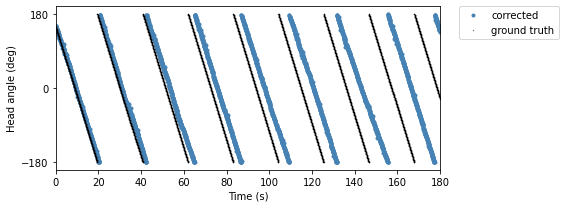

In [15]:
# fig, ax = plt.subplots(1, 1,figsize=(5, 2),facecolor='w')
fig, ax = plt.subplots(1, 1,figsize=(8, 3),facecolor='w')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Head angle (deg)')

ax.plot(T/1000,modes*(180/np.pi),'.',label='corrected',color='steelblue')
ax.plot(np.array(time)/1000,(theta[:len(time)])*(180/np.pi),'.',markersize=.5,label='ground truth',color='black')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.xlim([0,sim_len/1000])
plt.yticks([-180,0,180])
plt.tight_layout()
plt.savefig(f'data/{folder}/{folder}_drift.png')

To compare directly the ground truth and the estimated head angle we remove NaNs and interpolate the estimate to match the time series of the ground truth

In [16]:
nanidx = np.where(~np.isnan(modes[:-1]))
modes = modes[nanidx]
T=T[nanidx]

est = np.unwrap(modes)
groundTruth = np.unwrap(theta[:len(time)])

estimate = np.interp(time, T, est)

hd_estimate = np.vstack([T,modes])
np.save(f'data/{folder}/{folder}_estimate.npy',hd_estimate)

The difference between the estimated head angle and the ground truth is used to show how accumulation of drift over time, with total error measured as Root Mean Squared Error (RMSE).

87.48715254575187


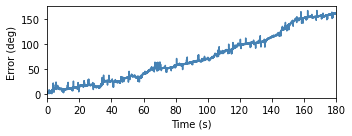

In [17]:
fig, ax = plt.subplots(1, 1,figsize=(5, 2),facecolor='w')

d = (groundTruth-estimate)
plt.plot(np.array(time)/1000,abs(d)*(180/np.pi),color='steelblue')
plt.xlabel('Time (s)')
plt.ylabel('Error (deg)')
plt.xlim([0,sim_len/1000])

RMSE = np.sqrt(np.sum(d**2)/len(d))
print(RMSE*(180/np.pi))

plt.tight_layout()
plt.savefig(f'data/{folder}/{folder}_error.png')

Polar plot showing the prefered firing direction of individual head direction cells

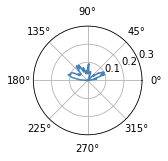

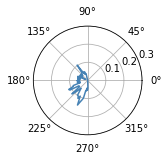

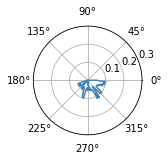

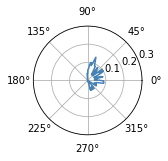

In [18]:
ev = sim.GetStatus(exc_spikes)[0]['events']
t = ev['times']
sp = ev['senders']

shrunk = list(theta[:len(time)])
for cell in range(0,N_ex,N_ex//4):
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if len(idx[0]):
            angle = shrunk[idx[0][0]]
            angles.append(angle)
    av = np.average(angles)
    fig, ax = plt.subplots(figsize=(2,2), subplot_kw={'projection': 'polar'})
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers,h1,color = 'steelblue')
#     ax.plot(np.ones(3)*av,np.arange(0,.3,.1),color='darkgrey')
    ax.set_yticks([.1,.2,.3])


Polar plots showing the prefered direction of individual cells in the first and third minute of the simulation

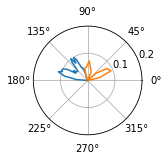

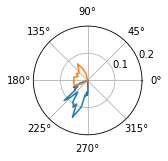

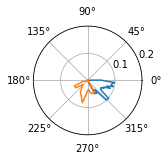

In [19]:
for cell in [0,45,90]:
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles1 = []
    angles2 = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if spktm < sim_len//2:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles1.append(angle)
        else:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles2.append(angle)
    fig, ax = plt.subplots(figsize=(2,2), subplot_kw={'projection': 'polar'})
    hist, bin_edges = np.histogram(angles1, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers,h1)
    ax.set_yticks([.1,.2])
    hist, bin_edges = np.histogram(angles2, bins=np.arange(-np.pi,np.pi,np.pi/20))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/20))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers,h1)
    ax.set_yticks([.1,.2])


Polar plots showing the prefered direction of three cells in the first and third minute of the simulation

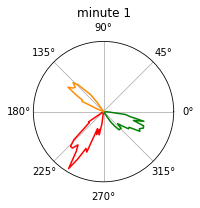

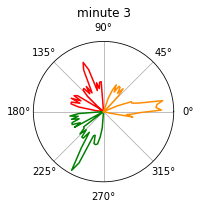

In [21]:
cells = [40,85,170]
colour = ['red','blue','green','orange']
colour = ['red','green','darkorange','orange']
fig, ax = plt.subplots(figsize=(3,3), subplot_kw={'projection': 'polar'})
for i,cell in enumerate(cells):
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if spktm < sim_len//3:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles.append(angle)
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers,h1,color=colour[i])
    ax.set_yticks([])
plt.title('minute 1')
plt.tight_layout()
plt.savefig(f'data/{folder}/{folder}_min1',format='svg')

fig, ax = plt.subplots(figsize=(3,3), subplot_kw={'projection': 'polar'})
for i,cell in enumerate(cells):
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if spktm > (sim_len//3)*2:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles.append(angle)
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers,h1,color=colour[i])
    ax.set_yticks([])
plt.title('minute 3')
plt.tight_layout()
plt.savefig(f'data/{folder}/{folder}_min3',format='svg')